## Train biologically informed NN on brain data

In [1]:
import pickle
import json
import torch
import pandas as pd
from torch.utils.data import Dataset
from cancernet import PnetDataSet, ReactomeNetwork
from cancernet.dataset import get_layer_maps
import numpy as np
import os

import time
import os
import torch
import torch_geometric.transforms as T
from torch.utils.data.sampler import SubsetRandomSampler
from torch_geometric.loader import DataLoader
import pytorch_lightning as pl

import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_score,

    recall_score,
)

from cancernet.arch import PNet
from cancernet.util import ProgressBar, InMemoryLogger, get_roc
from cancernet import PnetDataSet, BrainDataSet, ReactomeNetwork
from cancernet.dataset import get_layer_maps

/ext3/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
brain_dataset=BrainDataSet("data/brain/brain_vector.pkl","data/brain/response.csv","data/brain/brain_genes.json")
## Inspect train, val, test balance of pos/neg
print("train=",sum(brain_dataset.y[brain_dataset.train_idx])/len(brain_dataset.y[brain_dataset.train_idx]))
print("val=",sum(brain_dataset.y[brain_dataset.valid_idx])/len(brain_dataset.y[brain_dataset.valid_idx]))
print("test=",sum(brain_dataset.y[brain_dataset.test_idx])/len(brain_dataset.y[brain_dataset.test_idx]))

train= tensor([0.4110])
val= tensor([0.4203])
test= tensor([0.4203])


/home/cp3759/Projects/cancer-net-fresh/cancernet/dataset/pnet_dataset.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x=torch.tensor(self.x,dtype=torch.float32)


In [3]:
## Load Reactome pathways
reactome_kws = dict(
    reactome_base_dir=os.path.join("data", "reactome"),
    relations_file_name="ReactomePathwaysRelation.txt",
    pathway_names_file_name="ReactomePathways.txt",
    pathway_genes_file_name="ReactomePathways.gmt",
)
reactome = ReactomeNetwork(reactome_kws)

## Get Reactome masks
maps = get_layer_maps(
    genes=brain_dataset.genes,
    reactome=reactome,
    n_levels=6, ## Number of P-NET layers to include
    direction="root_to_leaf",
    add_unk_genes=False,
    verbose=False,
)

pathways 1507
genes 9186
pathways 1397
genes 1515
pathways 1066
genes 1399
pathways 447
genes 1068
pathways 147
genes 448
pathways 26
genes 147
pathways 1
genes 26


To randomly scramble gene connections, permute the maps in each layer using the following:
```
for aa in range(len(maps)):
    np.random.seed(42)
    maps[aa]=np.random.permutation(maps[aa].to_numpy())
```

In [4]:
# Set random seed
pl.seed_everything(150, workers=True)

n_epochs = 50
batch_size = 10
lr = 0.001

[rank: 0] Global seed set to 150


In [5]:
num_workers = 0
train_loader = DataLoader(
    brain_dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(brain_dataset.train_idx),
    num_workers=num_workers,
)
valid_loader = DataLoader(
    brain_dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(brain_dataset.valid_idx),
    num_workers=num_workers,
)

In [6]:
model = PNet(
    layers=maps,
    num_genes=maps[0].shape[0],
    lr=lr,
    class_weights=False
)

print("Number of params:",sum(p.numel() for p in model.parameters()))
logger = InMemoryLogger()


t0 = time.time()
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=n_epochs,
    callbacks=[ProgressBar()],
    logger=logger,
    # deterministic=True,
)
trainer.fit(model, train_loader, valid_loader)
print(f"Training took {time.time() - t0:.1f} seconds.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of params: 74201


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | network           | ModuleList | 60.4 K
1 | intermediate_outs | ModuleList | 13.8 K
-------------------------------------------------
74.2 K    Trainable params
0         Non-trainable params
74.2 K    Total params
0.297     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
/ext3/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have ma

Training took 33.5 seconds.


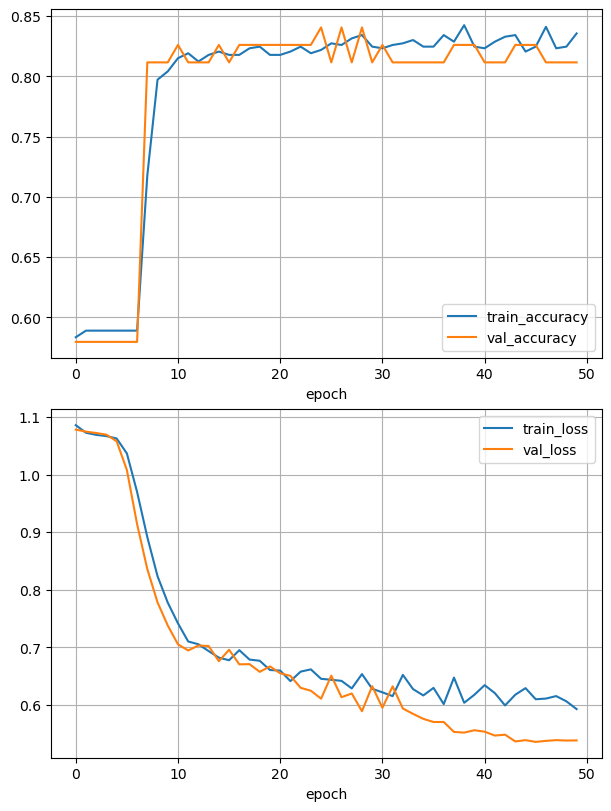

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)
logger.metrics_df.plot("epoch", ["train_accuracy", "val_accuracy"], ax=ax1)
ax1.grid()

logger.metrics_df.plot("epoch", ["train_loss", "val_loss"], ax=ax2)
ax2.grid()

accuracy 0.8260869565217391
auc 0.9413793103448276
aupr 0.8704395325640166
f1 0.7692307692307693
precision 0.8695652173913043
recall 0.6896551724137931


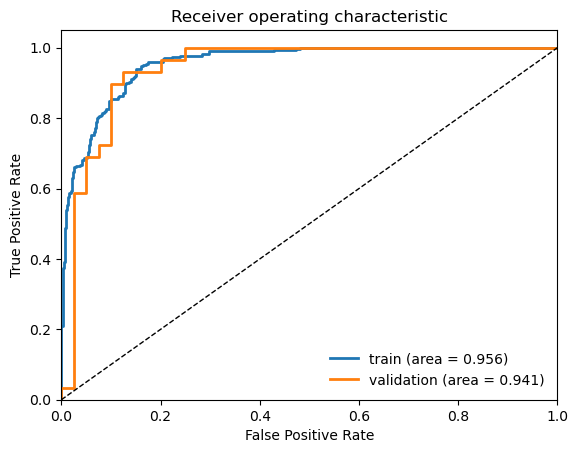

In [8]:
fpr_train, tpr_train, train_auc, _, _ = get_roc(model, train_loader,exp=False)
fpr_valid, tpr_valid, valid_auc, ys, outs = get_roc(model, valid_loader,exp=False)

fig, ax = plt.subplots()
ax.plot(fpr_train, tpr_train, lw=2, label="train (area = %0.3f)" % train_auc)
ax.plot(fpr_valid, tpr_valid, lw=2, label="validation (area = %0.3f)" % valid_auc)
ax.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver operating characteristic")
ax.legend(loc="lower right", frameon=False)

print("accuracy", accuracy_score(ys, outs[:, 1] > 0.5))
print("auc", valid_auc)
print("aupr", average_precision_score(ys, outs[:, 1]))
print("f1", f1_score(ys, outs[:, 1] > 0.5))
print("precision", precision_score(ys, outs[:, 1] > 0.5))
print("recall", recall_score(ys, outs[:, 1] > 0.5))